In [ ]:
!pip -q install apyori


  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
from google.colab import files
from io import StringIO


# Carregar o arquivo CSV
uploaded = files.upload()

# Identificar o nome do arquivo
filename = list(uploaded.keys())[0]
file_content = uploaded[filename]

# Tentar ler com diferentes delimitadores
try:
    # Tentativa 1: Delimitador padrão (vírgula)
    data = pd.read_csv(StringIO(file_content.decode('utf-8')), delimiter=',')
    print("Arquivo lido com vírgula como delimitador:")
    print(data.head())
except:
    print("Erro ao tentar ler com vírgula. Tentando com ponto e vírgula...")

    # Tentativa 2: Delimitador ponto e vírgula
    try:
        data = pd.read_csv(StringIO(file_content.decode('utf-8')), delimiter=';')
        print("Arquivo lido com ponto e vírgula como delimitador:")
        print(data.head())
    except:
        print("Erro ao tentar ler com ponto e vírgula. Tentando com tabulação...")

        # Tentativa 3: Delimitador tabulação
        try:
            data = pd.read_csv(StringIO(file_content.decode('utf-8')), delimiter='\t')
            print("Arquivo lido com tabulação como delimitador:")
            print(data.head())
        except:
            print("Não foi possível ler o arquivo com os delimitadores testados.")

# Se o arquivo foi lido corretamente, renomear as colunas
if 'data' in locals():
    # Exibir informações sobre o DataFrame
    print(data.info())

    # Renomear as colunas, caso necessário
    colunas_corrigidas = ['Produto', 'Quantidade', 'Preço Unitário', 'Total', 'Linha de Produto', 'Tipo de Cliente', 'Gênero', 'Cidade']
    if len(data.columns) == len(colunas_corrigidas):
        data.columns = colunas_corrigidas
        print("Colunas renomeadas com sucesso!")

    # Verificar as primeiras linhas dos dados
    print(data.head(20))



Saving dataset_vendas_supermercado.csv to dataset_vendas_supermercado (1).csv
Arquivo lido com vírgula como delimitador:
        Produto  Quantidade  Preço Unitário  Total Linha de Produto  \
0  Carne Bovina         1.0            25.0   25.0           Carnes   
1         Sabão         1.0             8.0    8.0          Limpeza   
2        Frango         1.0            12.0   12.0           Carnes   
3    Detergente         1.0             3.5    3.5          Limpeza   
4         Leite         8.0             4.5   36.0       Laticínios   

   Tipo de Cliente     Gênero          Cidade  
0  Pessoa Jurídica   Feminino  Rio de Janeiro  
1  Pessoa Jurídica   Feminino  Rio de Janeiro  
2  Pessoa Jurídica   Feminino  Rio de Janeiro  
3  Pessoa Jurídica   Feminino  Rio de Janeiro  
4    Pessoa Física  Masculino    Porto Alegre  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33162 entries, 0 to 33161
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ----

In [ ]:
print(data.head())

        Produto  Quantidade  Preço Unitário  Total Linha de Produto  \
0  Carne Bovina         1.0            25.0   25.0           Carnes   
1         Sabão         1.0             8.0    8.0          Limpeza   
2        Frango         1.0            12.0   12.0           Carnes   
3    Detergente         1.0             3.5    3.5          Limpeza   
4         Leite         8.0             4.5   36.0       Laticínios   

   Tipo de Cliente     Gênero          Cidade  
0  Pessoa Jurídica   Feminino  Rio de Janeiro  
1  Pessoa Jurídica   Feminino  Rio de Janeiro  
2  Pessoa Jurídica   Feminino  Rio de Janeiro  
3  Pessoa Jurídica   Feminino  Rio de Janeiro  
4    Pessoa Física  Masculino    Porto Alegre  


In [ ]:
# Removendo espaços em branco das colunas
for index in data.columns:
  if data[index].dtype == 'object':
    data[index] = data[index].str.strip()

In [ ]:
# Verificar valores nulos em todo o dataset
nulos = data.isnull().sum()

# Exibir as colunas com valores nulos
print("Valores nulos de cada coluna: \n")
print(nulos[nulos > 0]) # Mostra apenas as colunas que possuem valores nulos

Valores nulos de cada coluna: 

Quantidade    713
Cidade        660
dtype: int64


In [ ]:
# Verificar quantos produtos distintos existem na coluna produtos
if 'Produto' in data.columns:
  itens=data['Produto'].dropna().sort_values()
  print(f'\nExistem {itens.nunique()} produtos distintos:\n', itens.nunique())
else:
  print("A coluna 'Produto' não foi encontrada!")


Existem 10 produtos distintos:
 10


In [ ]:
print('Checando duplicidade de valores')
print(data.duplicated().value_counts())

Checando duplicidade de valores
True     30262
False     2900
Name: count, dtype: int64


Text(0, 0.5, 'Quantidade')

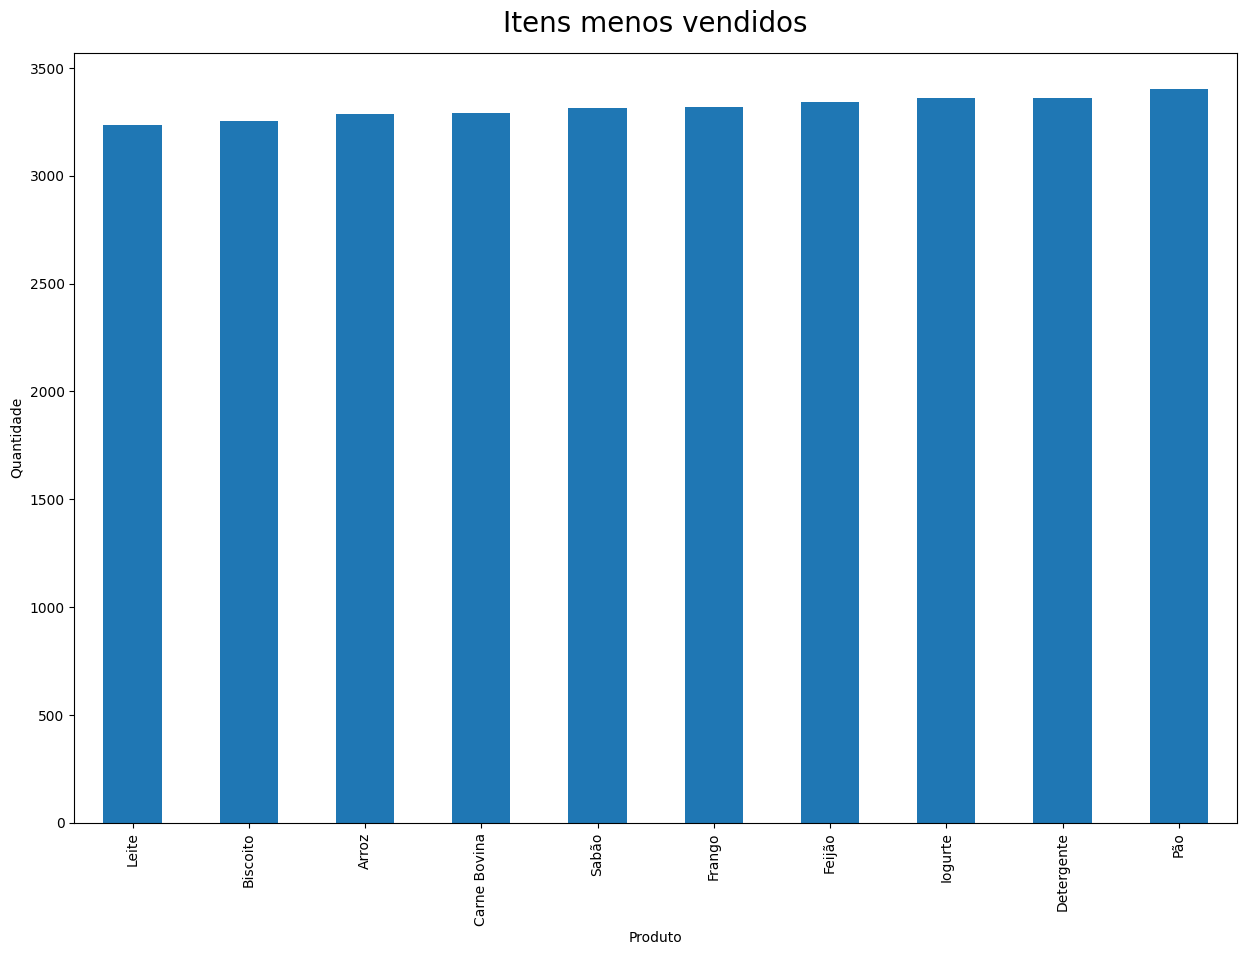

In [ ]:
qtd_itens= itens.value_counts()
barra = qtd_itens.nsmallest(10).plot(kind='bar')
barra.set_title('Itens menos vendidos', size=20, weight=500, pad=15)
barra.set_ylabel('Quantidade')

In [ ]:
from itertools import combinations
from tqdm import tqdm
# Adicionar uma coluna de ID de venda
data['ID de Venda'] = data.groupby(['Linha de Produto', 'Tipo de Cliente', 'Gênero']).ngroup()

# Agrupar os produtos por ID de Venda e filtrando cestas com mais de 1 item
cestas = data.groupby('ID de Venda')['Produto'].apply(list)
cestas = cestas[cestas.apply(len) > 1]

# Armazenar a contagem das combinações
contagem = {}

# Tamanho das combinações desejadas
tamanhos = [2, 3]
total_cestas = len(cestas)
with tqdm(total=total_cestas) as pbar:
  for cesta in cestas:
    for tamanho in tamanhos:
      if len(cestas) >= tamanho:
        for combinacao in combinations(cesta, tamanho):
          # contagem[combinacao] in combinations(cesta, tamanho)
          if combinacao in contagem:
            contagem[combinacao] += 1
          else:
            contagem[combinacao] = 1
        pbar.update(1)

# Selecionando as 10 combinacoes mais presentes
top_combinacao = sorted(contagem.items(), key=lambda item:item[1], reverse=True)[:10]

# Selecionando as combinações mais frequentes
bottom_combinacoes = sorted(contagem.items(), key=lambda item:item[1])[:10]

# Exibindo as combinações comuns
print('\nCombinações comuns:')
for combinacao, frequencia in top_combinacao:
  print(f'{combinacao}:{frequencia}')

# Exibindo as combinações improváveis
print('\nCombinações improváveis:')
for combinacao, frequencia in bottom_combinacoes:
  print(f'{combinacao}:{frequencia}')

48it [1:20:57, 101.20s/it]


Combinações comuns:
('Pão', 'Pão', 'Pão'):409553853
('Sabão', 'Detergente', 'Detergente'):403203267
('Iogurte', 'Iogurte', 'Iogurte'):394332440
('Detergente', 'Detergente', 'Detergente'):394214910
('Sabão', 'Detergente', 'Sabão'):391264071
('Sabão', 'Sabão', 'Detergente'):391235796
('Arroz', 'Feijão', 'Feijão'):389298026
('Feijão', 'Feijão', 'Feijão'):388407390
('Iogurte', 'Leite', 'Iogurte'):387619402
('Feijão', 'Arroz', 'Feijão'):384942822

Combinações improváveis:
('Leite', 'Leite'):1305116
('Biscoito', 'Biscoito'):1326224
('Iogurte', 'Leite'):1346689
('Arroz', 'Arroz'):1347763
('Carne Bovina', 'Carne Bovina'):1351588
('Feijão', 'Arroz'):1353491
('Carne Bovina', 'Frango'):1363430
('Frango', 'Carne Bovina'):1366826
('Detergente', 'Sabão'):1367733
('Leite', 'Iogurte'):1368520


In [ ]:
len(cestas)

24

In [ ]:
from apyori import apriori
import pandas as pd

# Supondo que 'cesta' sejam uma lista de listas, onde cada sublista é uma cesta de produtos
# Converter os objetos em série para uma lista com as listas
cesta_list = cestas.tolist()

# Gerar regras de associação
regras = apriori(cesta_list, min_suport=0.01, min_confindence=0.5, min_lift=1.5, min_length=2)

# Convertendo as regras para lista
resultados = list(regras)

# Criando uma lista para armazenar os dados das regras
itens_comprados = []
suportes = []
confiancas = [] # Qual é a porcentagem

# Extraindo dados das regras
for resultado in resultados:
  itens = list(resultado.items)
  suporte = resultado.support
  # Extraindo a confiança da primeira estatística da regra
  confianca = resultado.ordered_statistics[0].confidence if resultado.ordered_statistics else 0
  # Adicionando dados a lista
  itens_comprados.append(', '.join(itens)) # Convertendo os itens para uma string
  suportes.append(suporte)
  confiancas.append(confianca)
# Criando um DataFrame para exibir os resultados em forme de tabela
tabela_regras = pd.DataFrame({
  'Produtos Comprados Juntos: ': itens_comprados,
  'Suporte': suportes,
  'Confianca': confiancas
})

# Selecionando as 10 combinações mais frequentes
comb_comuns = tabela_regras.nlargest(10, 'Suporte')
# Selecionando as 10 combinações menos frequentes
comb_incomuns = tabela_regras.nsmallest(10, 'Suporte')

# Exibindo combinações comuns
print('\nCombinações comuns: ')
print(comb_comuns)

# Exibindo as combinações incomuns:
print('\nCombinações incomuns: ')
print(comb_incomuns)


Combinações comuns: 
  Produtos Comprados Juntos:    Suporte  Confianca
0               Feijão, Arroz  0.166667        1.0
1        Carne Bovina, Frango  0.166667        1.0
2           Detergente, Sabão  0.166667        1.0
3              Leite, Iogurte  0.166667        1.0

Combinações incomuns: 
  Produtos Comprados Juntos:    Suporte  Confianca
0               Feijão, Arroz  0.166667        1.0
1        Carne Bovina, Frango  0.166667        1.0
2           Detergente, Sabão  0.166667        1.0
3              Leite, Iogurte  0.166667        1.0


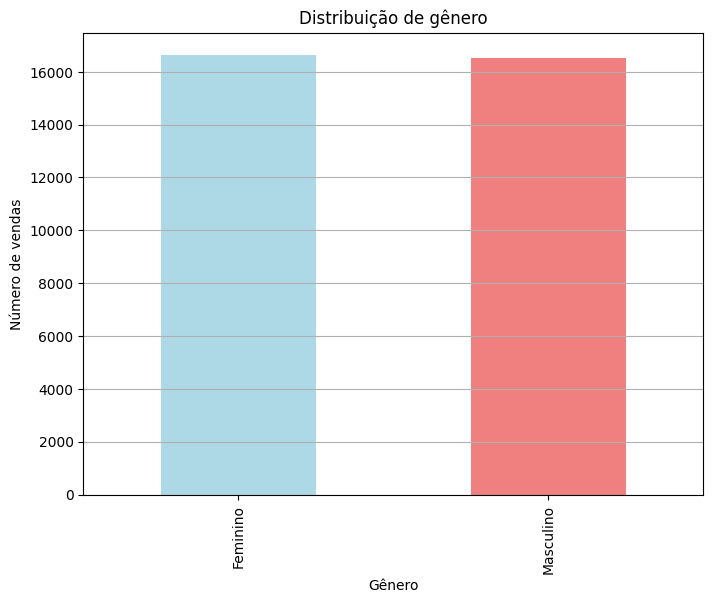

In [ ]:
import matplotlib.pyplot as plt

distribuicao_genero = data['Gênero'].value_counts()
plt.figure(figsize=(8,6))
distribuicao_genero.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribuição de gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de vendas')
plt.grid(axis='y')
plt.show()

<Figure size 800x600 with 0 Axes>

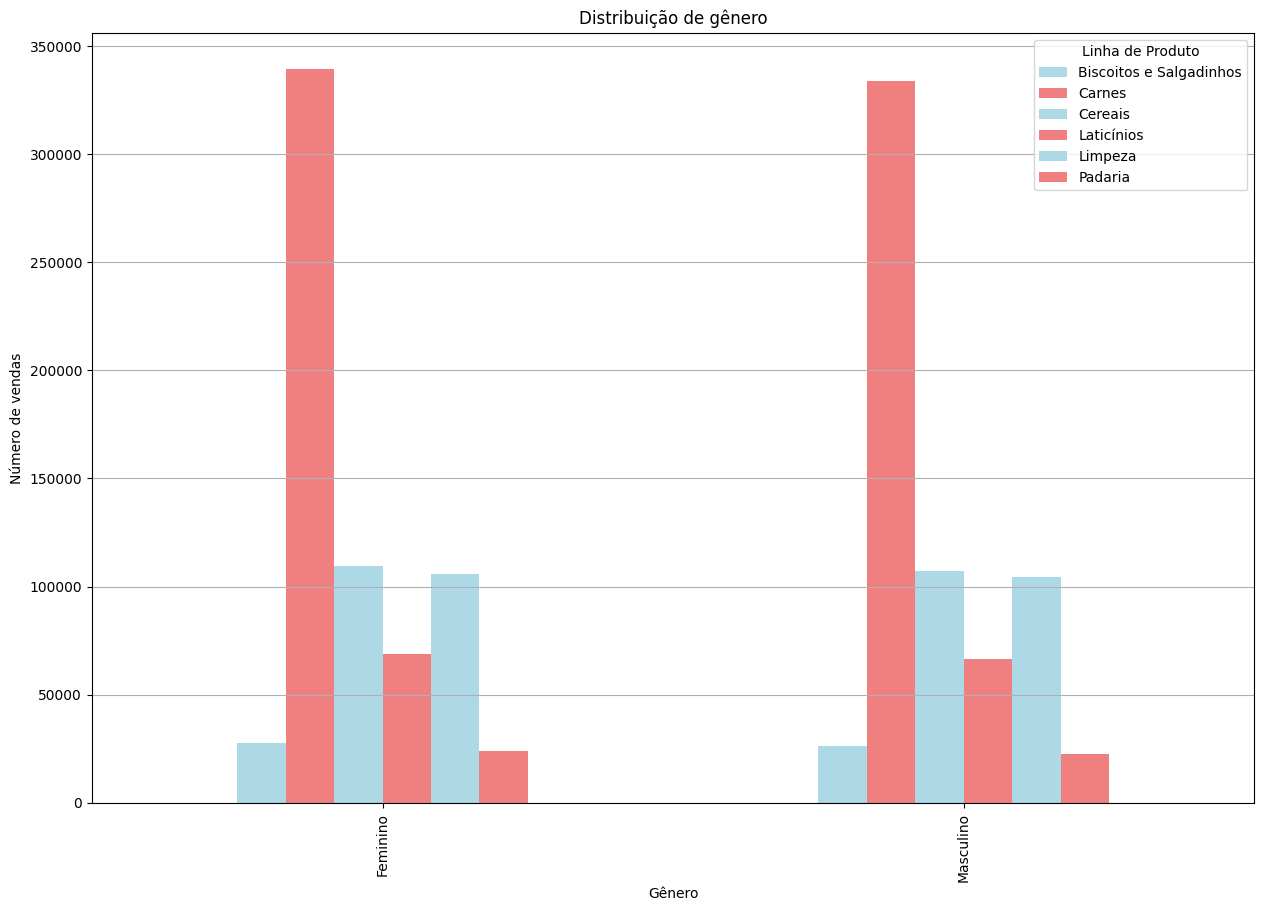

In [ ]:
import matplotlib.pyplot as plt

distribuicao_genero = data.groupby(['Gênero', 'Linha de Produto'])['Total'].sum().unstack().fillna(0)
plt.figure(figsize=(8,6))
distribuicao_genero.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribuição de gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de vendas')
plt.grid(axis='y')
plt.show()